In [1]:
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymutspec.constants import possible_codons, possible_sbs96, possible_sbs192
from pymutspec.annotation import rev_comp
from pymutspec.draw import plot_mutspec96

/home/kpotoh/carp/.venv/lib/python3.10/site-packages/ete3/evol/evoltree.py:86: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy.stats import chi2


## Mutational signature

Expectations: C>T, T>A, T>C

![image.png](attachment:image.png)

### Load OBS

In [11]:
df_dnm = pd.read_csv('./data/results/dnm_GQ60.csv')
df_dnm = df_dnm[df_dnm.TYPE == 'SNP']
df_dnm

,CHROM,POS,TYPE,hiConfDeNovo,proband.GT,proband.AD,proband.PL,proband.GQ,proband.DP,mother.GT,...,father.DP,proband.AB,mother.AB,father.AB,is_low_complex_region,Consequence,IMPACT,BIOTYPE,SAMPLE,GROUP
0,NC_056574.1,5954832,SNP,"CAR2463,CAR2484",G|C,"14,6","210,0,570",99.0,20.0,G/G,...,26.0,0.300000,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2463,ctrl
11,NC_056618.1,26615985,SNP,CAR2463,G/A,"6,6","169,0,179",99.0,12.0,G/G,...,33.0,0.500000,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2463,ctrl
14,NC_056576.1,9112567,SNP,"CAR2464,CAR2474,CAR2491",A|C,"15,6","149,0,612",99.0,21.0,A/A,...,24.0,0.285714,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2464,ctrl
16,NC_056579.1,11038748,SNP,"CAR2464,CAR2479,CAR2490",T/G,"8,10","352,0,292",99.0,18.0,T/T,...,28.0,0.555556,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2464,ctrl
21,NC_056600.1,10798476,SNP,CAR2464,G/A,"14,7","184,0,446",99.0,21.0,G/G,...,35.0,0.333333,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2464,ctrl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,NC_056617.1,6371416,SNP,CAR2492,G/A,"8,10","274,0,287",99.0,18.0,G/G,...,24.0,0.555556,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2492,nem
1422,NC_056617.1,8930071,SNP,CAR2492,A|T,"8,7","270,0,315",99.0,15.0,A/A,...,20.0,0.466667,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2492,nem
1423,NC_056618.1,25873382,SNP,CAR2492,T/C,"6,7","203,0,167",99.0,13.0,T/T,...,39.0,0.538462,0.0,0.0,False,downstream_gene_variant,MODIFIER,protein_coding,CAR2492,nem
1427,NC_056619.1,16483389,SNP,CAR2492,A/T,"7,6","163,0,235",99.0,15.0,A/A,...,28.0,0.461538,0.0,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2492,nem


In [12]:
# all parents genotypes are equal
df_dnm[df_dnm['mother.GT'] != df_dnm['father.GT']][['mother.GT', 'father.GT']]

,mother.GT,father.GT
87,T|T,T/T
99,C|C,C/C
371,A|A,A/A
406,A/A,A|A
490,A|A,A/A
520,C|C,C/C
646,T|T,T/T
890,C/C,C|C
897,C/C,C|C
927,A|A,A/A


In [13]:
_ = df_dnm[[ 'proband.GT', 'mother.GT', 'father.GT']]
assert (_['proband.GT'].str[0] == _['mother.GT'].str[0]).all()
assert (_['proband.GT'].str[2] != _['mother.GT'].str[0]).all()

df_dnm['sbs12'] = df_dnm['mother.GT'].str[0] + '>' + df_dnm['proband.GT'].str[2]
df_dnm[[ 'proband.GT', 'mother.GT', 'father.GT', 'sbs12']]

,proband.GT,mother.GT,father.GT,sbs12
0,G|C,G/G,G/G,G>C
11,G/A,G/G,G/G,G>A
14,A|C,A/A,A/A,A>C
16,T/G,T/T,T/T,T>G
21,G/A,G/G,G/G,G>A
...,...,...,...,...
1421,G/A,G/G,G/G,G>A
1422,A|T,A/A,A/A,A>T
1423,T/C,T/T,T/T,T>C
1427,A/T,A/A,A/A,A>T


Text(0, 0.5, 'ObsNum')

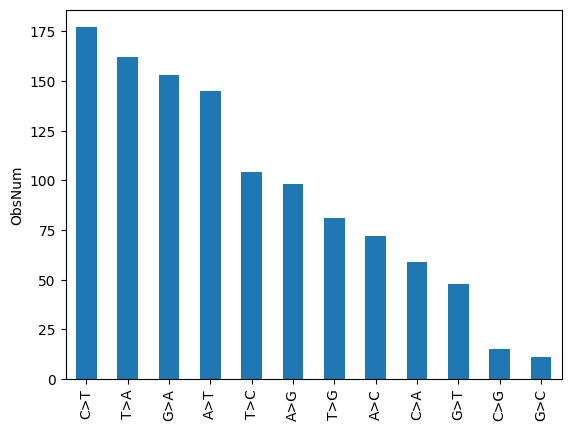

In [14]:
df_dnm[df_dnm.TYPE != 'INDEL'].sbs12.value_counts().plot.bar()
plt.ylabel('ObsNum')

### Collect contexts for DNMs and Estimate EXP

In [6]:
from Bio import SeqIO
path_to_ref = './data/ref/GCF_018340385.1_ASM1834038v1_genomic.fna'
fasta_dict = SeqIO.to_dict(SeqIO.parse(path_to_ref, "fasta"))

In [15]:
# collect contexts for DNMs
cxts_data = []
for i, row in df_dnm.iterrows():
    if row.TYPE == 'SNP':
        chrom, pos = row['CHROM'], row['POS']-1
        ref_nuc = row['mother.GT'][0]
        assert fasta_dict[chrom][pos].upper() == ref_nuc, (i, row.values, row['mother.GT'], ref_nuc)
        cur_cxt = str(fasta_dict[chrom][pos-1: pos+2].seq)
        cxts_data.append(cur_cxt.upper())
    else:
        cxts_data.append(np.nan)

In [16]:
df_dnm['Cxt'] = cxts_data
df_dnm['Mut'] = df_dnm.apply(lambda x: f"{x.Cxt[0]}[{x.sbs12}]{x.Cxt[2]}", axis=1)

In [17]:
df_dnm

,CHROM,POS,TYPE,hiConfDeNovo,proband.GT,proband.AD,proband.PL,proband.GQ,proband.DP,mother.GT,...,father.AB,is_low_complex_region,Consequence,IMPACT,BIOTYPE,SAMPLE,GROUP,sbs12,Cxt,Mut
0,NC_056574.1,5954832,SNP,"CAR2463,CAR2484",G|C,"14,6","210,0,570",99.0,20.0,G/G,...,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2463,ctrl,G>C,TGA,T[G>C]A
11,NC_056618.1,26615985,SNP,CAR2463,G/A,"6,6","169,0,179",99.0,12.0,G/G,...,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2463,ctrl,G>A,TGA,T[G>A]A
14,NC_056576.1,9112567,SNP,"CAR2464,CAR2474,CAR2491",A|C,"15,6","149,0,612",99.0,21.0,A/A,...,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2464,ctrl,A>C,GAT,G[A>C]T
16,NC_056579.1,11038748,SNP,"CAR2464,CAR2479,CAR2490",T/G,"8,10","352,0,292",99.0,18.0,T/T,...,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2464,ctrl,T>G,CTG,C[T>G]G
21,NC_056600.1,10798476,SNP,CAR2464,G/A,"14,7","184,0,446",99.0,21.0,G/G,...,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2464,ctrl,G>A,CGA,C[G>A]A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,NC_056617.1,6371416,SNP,CAR2492,G/A,"8,10","274,0,287",99.0,18.0,G/G,...,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2492,nem,G>A,TGG,T[G>A]G
1422,NC_056617.1,8930071,SNP,CAR2492,A|T,"8,7","270,0,315",99.0,15.0,A/A,...,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2492,nem,A>T,CAA,C[A>T]A
1423,NC_056618.1,25873382,SNP,CAR2492,T/C,"6,7","203,0,167",99.0,13.0,T/T,...,0.0,False,downstream_gene_variant,MODIFIER,protein_coding,CAR2492,nem,T>C,GTA,G[T>C]A
1427,NC_056619.1,16483389,SNP,CAR2492,A/T,"7,6","163,0,235",99.0,15.0,A/A,...,0.0,False,intron_variant,MODIFIER,protein_coding,CAR2492,nem,A>T,AAG,A[A>T]G


In [26]:
# funcs for specific data processing and writing

def read_triplet_counts(include_lower_nucls=True):
    with open("./data/interim/cor/triplet_counts.json") as fin:
        _human_counts_raw = json.load(fin)
        if include_lower_nucls:
            human_counts = defaultdict(int)
            for triplet, n in _human_counts_raw.items():
                human_counts[triplet.upper()] += n
            human_counts = dict(human_counts)        
        else:
            # without aAa, tAA, tgc etc. Only upper case
            _human_counts_raw = {x: _human_counts_raw[x] for x in possible_codons}
            human_counts = defaultdict(int)
            for triplet, n in _human_counts_raw.items():
                human_counts[triplet.upper()] += n
            human_counts = dict(human_counts)
        return human_counts

In [90]:
triplet_counts = read_triplet_counts(False)
exp_freqs = dict()
for cxt, cnt in triplet_counts.items():
    for nucl in 'ACGT':
        if cxt[1] == nucl:
            continue
        sbs = f'{cxt[0]}[{cxt[1]}>{nucl}]{cxt[2]}'
        exp_freqs[sbs] = cnt

In [91]:
df_dnm.groupby('GROUP'.split()).sbs12.value_counts().unstack()

sbs12,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
GROUP,,,,,,,,,,,,
ctrl,4,5,2,2,2,7,12,2,2,3,5,2
nem,27,38,72,20,3,89,60,2,16,80,40,28
nem-shok,41,55,71,37,10,81,81,7,30,79,59,51


In [92]:
spectrum = df_dnm[df_dnm.GROUP != 'ctrl'].groupby('Cxt').Mut.value_counts().rename('ObsNum').reset_index()
spectrum['ExpNum'] = spectrum.Cxt.map(triplet_counts)
del spectrum['Cxt']
spectrum['MutSpec'] = (spectrum['ObsNum'] / spectrum.ObsNum.sum()) / (spectrum['ExpNum']/spectrum.ExpNum.sum())
spectrum

,Mut,ObsNum,ExpNum,MutSpec
0,A[A>T]A,7,28940199,0.561635
1,A[A>G]A,2,28940199,0.160467
2,A[A>C]A,1,28940199,0.080234
3,A[A>G]C,14,16536318,1.965836
4,A[A>C]C,6,16536318,0.842501
...,...,...,...,...
156,T[T>C]G,6,18793746,0.741303
157,T[T>G]G,1,18793746,0.123551
158,T[T>A]T,5,28864295,0.402223
159,T[T>C]T,5,28864295,0.402223


In [93]:
from pymutspec.draw import plot_mutspec192, plot_mutspec96, plot_mutspec12
from pymutspec.constants import possible_sbs96

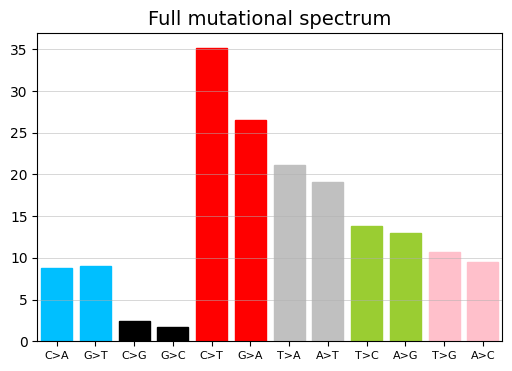

<Axes: title={'center': 'Full mutational spectrum'}>

In [94]:
_ = spectrum.copy()
_['Mut'] = _['Mut'].str[2:5]
plot_mutspec12(_.groupby('Mut').sum().reset_index())

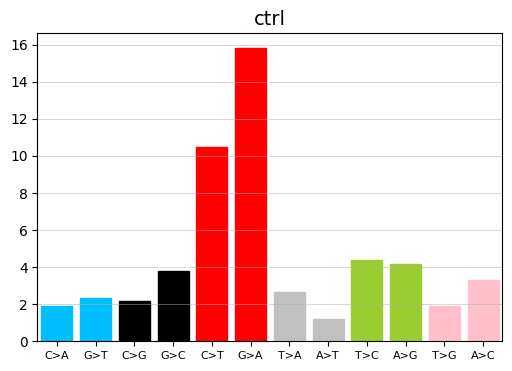

<Axes: title={'center': 'ctrl'}>

In [108]:
_ = df_dnm[df_dnm.GROUP == 'ctrl'].groupby('Cxt').Mut.value_counts().rename('ObsNum').reset_index()
_['ExpNum'] = _.Cxt.map(triplet_counts)
del _['Cxt']
_['MutSpec'] = (_['ObsNum'] / _.ObsNum.sum()) / (_['ExpNum']/_.ExpNum.sum())

_['Mut'] = _['Mut'].str[2:5]
plot_mutspec12(_.groupby('Mut').sum().reset_index(), title='ctrl')

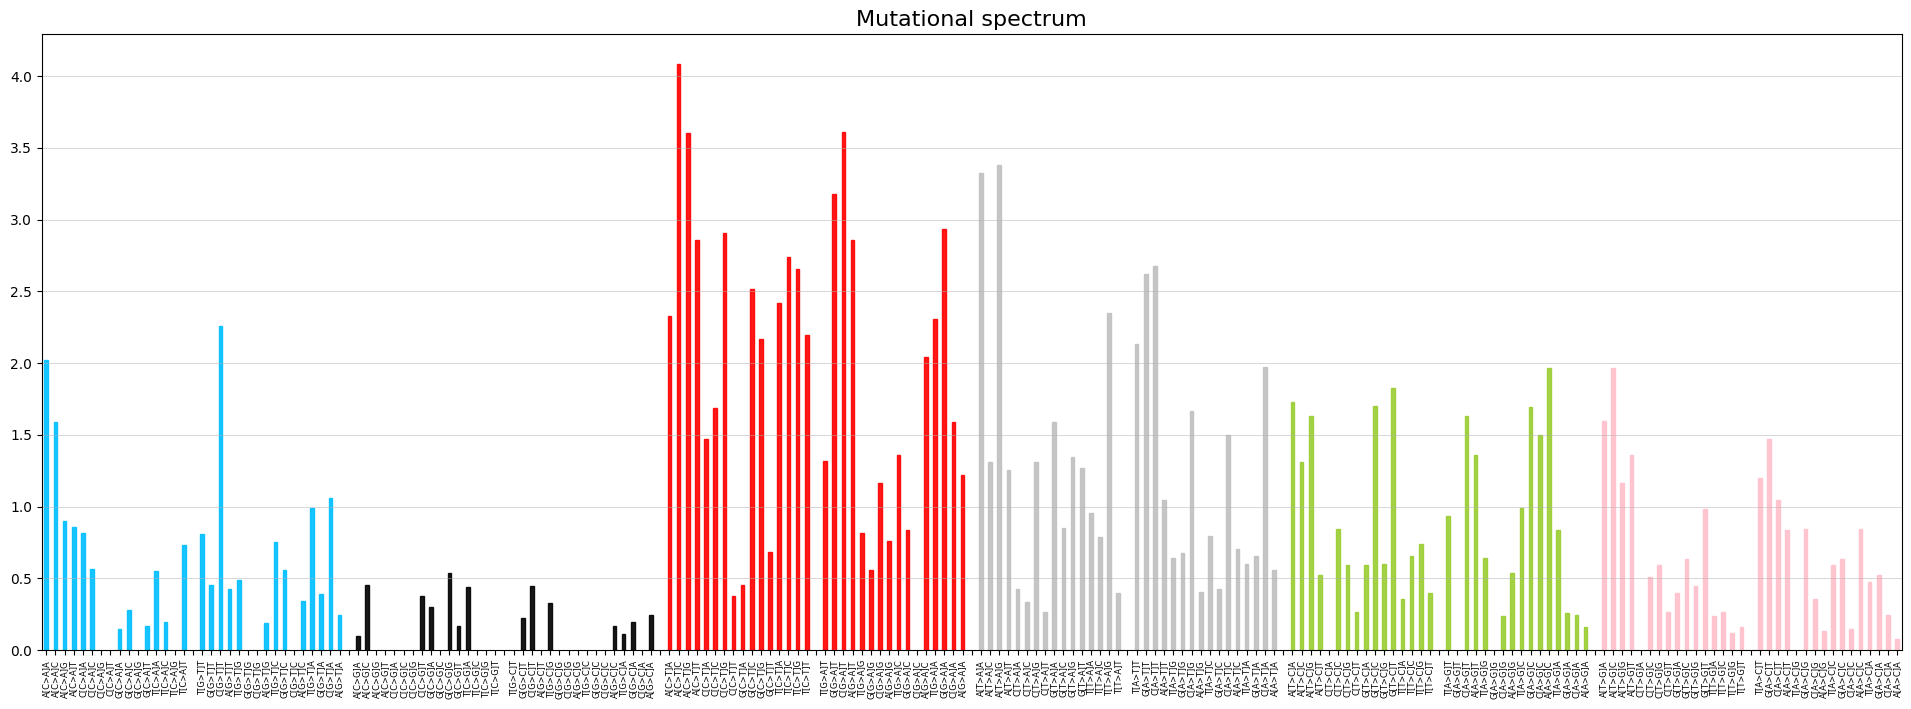

<Axes: title={'center': 'Mutational spectrum'}>

In [95]:
plot_mutspec192(spectrum)

In [96]:
spectrum.loc[~spectrum.Mut.isin(possible_sbs96), 'Mut'] = \
    spectrum.Mut[~spectrum.Mut.isin(possible_sbs96)].apply(rev_comp)

In [97]:
spectrum96 = spectrum.groupby('Mut').sum().reset_index()

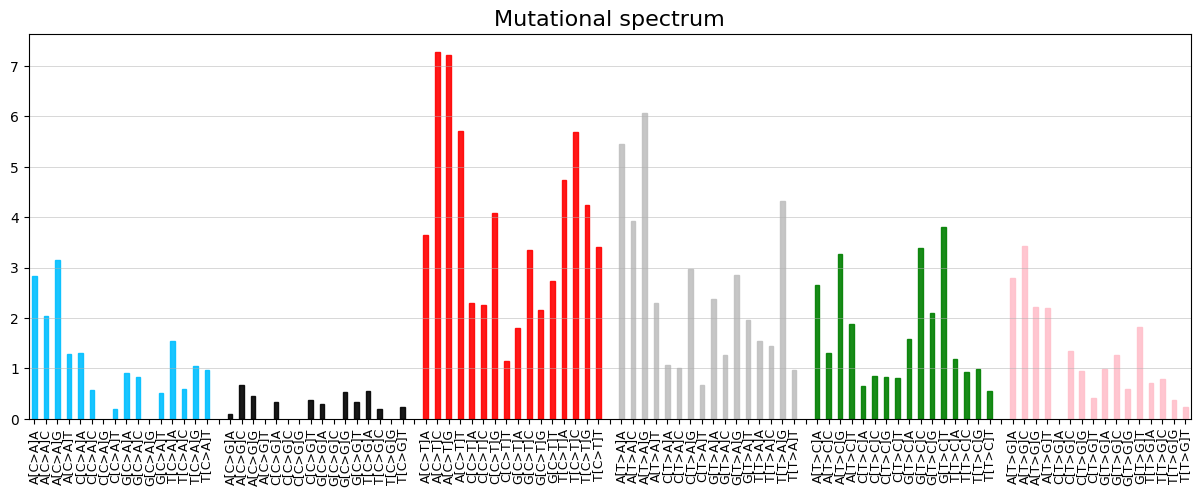

<Axes: title={'center': 'Mutational spectrum'}>

In [98]:
plot_mutspec96(spectrum96)

In [101]:
enu_signature = pd.read_csv('./data/enu_signature.csv')
enu_signature

,Mut,ENU_Kucab_2019
0,A[C>A]A,0.013048
1,A[C>A]C,0.004007
2,A[C>A]G,0.002212
3,A[C>A]T,0.004704
4,C[C>A]A,0.008825
...,...,...
91,G[T>G]T,0.002000
92,T[T>G]A,0.000787
93,T[T>G]C,0.001511
94,T[T>G]G,0.002702


In [102]:
from scipy.spatial.distance import cosine



In [107]:
_ = spectrum96.merge(enu_signature)
1-cosine(_['MutSpec'], _['ENU_Kucab_2019'])

0.6667516292393468